In [1]:
from random import choice
from nltk import CFG
from nltk import PCFG
import numpy as np
from timeit import default_timer as timer
from datetime import timedelta
import nltk

#### About
- Implementation for sampling from probabilistic context free grammars

#### Resources
- https://lost-contact.mit.edu/afs/cs.pitt.edu/projects/nltk/docs/tutorial/pcfg/nochunks.html

In [2]:
def sec_to_ms(s):
    m, s = divmod(s, 60)
    return '{:0>2} min {:.2f} sec'.format(m, s)

In [165]:
class Grammar():
    def __init__(self):
        self._G = None

    def from_string(self, string):
        self._G = PCFG.fromstring(string)
        self._parser = nltk.ViterbiParser(self._G)
        return self
    
    def sample(self, n=10):
        #return [' '.join(self._produce(self._G, self._G.start())) for _ in range(n)]
        return [self._produce(self._G, self._G.start()) for _ in range(n)]

    def _produce(self, grammar, symbol):
        words = []
        productions = grammar.productions(lhs = symbol)
        if len(productions) == 0:
            raise Exception("No rules to further expand available: lhs={}".format(symbol))
        all_probs = [p.prob() for p in productions]
        production = np.random.choice(productions, size=1, replace=True, p=all_probs)[0]
        for sym in production.rhs():
            if isinstance(sym, str):
                words.append(sym)
            else:
                words.extend(self._produce(grammar, sym))
        return words
    
    def is_valid(self, sentence):
        parsed = self._parser.parse(sentence)
        for subtree in parsed:
            if type(subtree) == nltk.tree.ProbabilisticTree and subtree.label() == 'S':
                return True
        return False
    
    def get_probs(self, sentence):
        parsed = self._parser.parse(sentence)
        probs = []
        for subtree in parsed:
            if type(subtree) == nltk.tree.ProbabilisticTree and subtree.label() == 'S':
                probs.append(subtree.prob())
        if len(probs) > 0:
            return probs
        raise Exception("Input is not a valid sentence!")
    
    def parse(self, sentence):
        return self._parser.parse(sentence)

### Simple Grammar

In [166]:
g = """
S -> A [1.0]
A -> 'a'B [0.5] | 'b'B [0.5]
B -> A [0.8] | 'c' [0.2]
"""
G = Grammar().from_string(g)
samples = G.sample(10)

for sample in samples:
    print("".join(sample))
    assert G.is_valid(sample)

aabbababc
babbbc
abac
aaabbbbbaababaaabaaac
abaaaabaaabbbababbc
abc
bc
babc
abc
ac


In [167]:
g = """
S -> 'a' A [1.0]
A -> "a" A [0.5] | B [0.5]
B -> "b" [1.0]
"""

G = Grammar().from_string(g)
samples = G.sample(10)
print(samples)
print(G.is_valid(samples[0]))

[['a', 'b'], ['a', 'a', 'b'], ['a', 'b'], ['a', 'a', 'b'], ['a', 'a', 'b'], ['a', 'b'], ['a', 'b'], ['a', 'a', 'a', 'b'], ['a', 'b'], ['a', 'b']]
True


### Verbose Grammar

In [175]:
g = """
S -> SEN [1.0]
SEN -> SE1 [0.5] | SE1 CONJ SEN [0.5]
SE1 -> SUB PRE OBJ [1.0]
CONJ -> 'or' [0.1] | 'and' [0.9]
SUB -> 'A' [0.3] | 'B' [0.4] | "C" [0.3]
PRE -> 'likes' [0.8] | 'does' [0.2]
OBJ -> 'hiking' [0.2] | 'swimming' [0.8]
"""

G = Grammar().from_string(g)
samples = G.sample(5)
#
for sample in samples:
    print(" ".join(sample))

B likes swimming
B likes swimming
B likes swimming and A likes swimming and A likes swimming
B likes swimming
C likes swimming or C likes swimming


In [176]:
# validate samples
s1 = "A does swimming"
s2 = "A does B"
print(G.is_valid(s1.split()))
print(G.is_valid(s2.split()))

# prob of generating a sample
print(G.get_probs(s1.split()))

True
False
[0.024]


In [178]:
for subtree in G.parse(s1.split()):
    print(subtree)

(S (SEN (SE1 (SUB A) (PRE does) (OBJ swimming)))) (p=0.024)


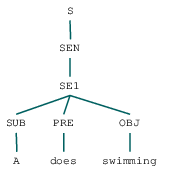

In [179]:
subtree

### Ambiguous Grammars

In [180]:
g = """
S -> A [0.5] | B [0.5]
A -> 'a' [1.0]
B -> 'a' [1.0]
"""
G = Grammar().from_string(g)
samples = G.sample(10)
print(samples)

[['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a']]


In [181]:
for sample in samples:
    print(G.is_valid(sample), G.get_probs(sample))

True [0.5]
True [0.5]
True [0.5]
True [0.5]
True [0.5]
True [0.5]
True [0.5]
True [0.5]
True [0.5]
True [0.5]
